In [1]:
import os
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

In [2]:
data_dir = "emotion dataset/test"
os.listdir(data_dir)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [9]:
project_name = "FER_2023_Emotion_Detection"

base_dir = "C:/Users/singh/College assignemnt/Resume Projects/Emotion Detection"

# List your models
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]


# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)

print(f'Project directory structure created at: {project_dir}')


Project directory structure created at: C:/Users/singh/College assignemnt/Resume Projects/Emotion Detection\FER_2023_Emotion_Detection


In [ ]:
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/emotional dataset/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

In [3]:
def count_files_in_subdirs(directory, set_name):
    counts = {}
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        if os.path.isdir(item_path):
            counts[item] = len(os.listdir(item_path))
    df = pd.DataFrame(counts, index=[set_name])
    return df
    
train_dir = 'emotion dataset/train'
test_dir = 'emotion dataset/test'

# Count the files 
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files 
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


<Axes: >

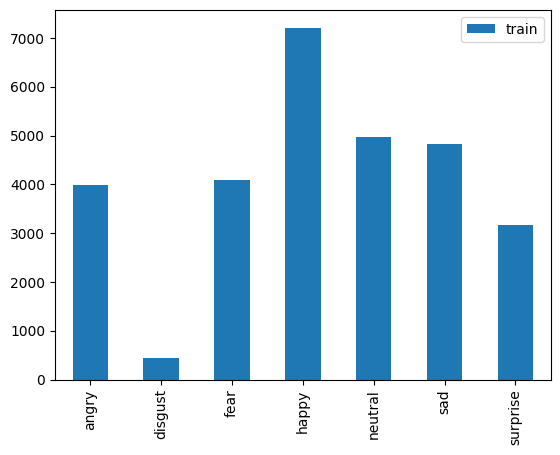

In [4]:
train_count.transpose().plot(kind='bar')

<Axes: >

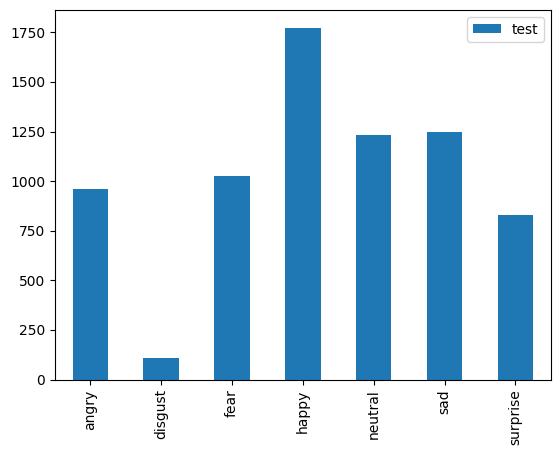

In [5]:
test_count.transpose().plot(kind='bar')

In [6]:
count = 0 
for folder in os.listdir(test_dir):
    images = os.path.join(test_dir , folder)
    for img_path in os.listdir(images):
        img = os.path.join(images , img_path)
        # print(len())
        count += 1
      
print(count)  

7178


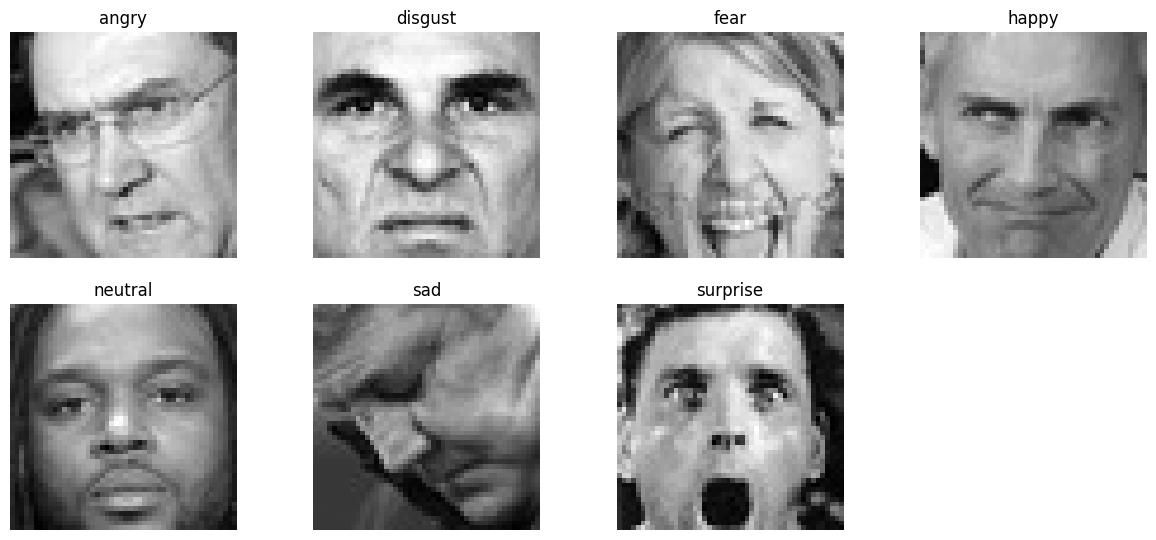

In [7]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

## Data Analysis 

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\singh\AppData\Local\Temp\ipykernel_2408\2608025624.py:1: SyntaxWarning: invalid escape sequence '\T'
  image = os.path.join(train_dir,"angry\Training_3908.jpg")


Shape: (48, 48, 3)


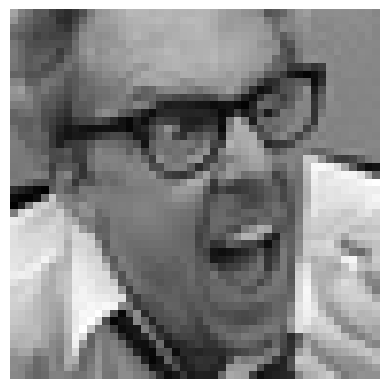

In [8]:
image = os.path.join(train_dir,"angry\Training_3908.jpg")
import cv2

img = cv2.imread(image) 

if img is not None:
    # print(img)
    plt.imshow(img)
    plt.axis(False)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded.")

In [9]:
import cv2

image_path = 'emotion dataset/train/angry/Training_10118481.jpg'

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if img is not None:
    print("Shape:", img.shape) 
else:
    print("The image could not be loaded.")

Shape: (48, 48)


## Custom CNN: From Scratch

In [10]:
# init Params
img_width, img_height = 48, 48  # Size of images
batch_size = 32
epochs = 10
num_classes = len(os.listdir(test_dir))

In [11]:
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)
    # subset='validation')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:

train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

#validation
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

#test
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [13]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

c:\Users\singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 11, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,046,535 (65.03 MB)

 Trainable params: 17,044,871 (65.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [15]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# File path for the model checkpoint
cnn_path = 'C:/Users/singh/College assignemnt/Resume Projects/Emotion Detection/FER_2023_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'C:/Users/singh/College assignemnt/Resume Projects/Emotion Detection/FER_2023_Emotion_Detection/Custom_CNN_From_Scratch\\Custom_CNN_model.keras'

In [18]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [ ]:
# Aggregating all callbacks 
callbacks = [earlystop] 


In [36]:
train_step_per_epoch = train_generator.samples // train_generator.batch_size+1 
valid_step_per_epoch = validation_generator.samples // validation_generator.batch_size+1 
test_step_per_epoch = test_generator.samples // test_generator.batch_size+1 

## Model Training

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_step_per_epoch,
    epochs = 1,
    validation_data = validation_generator,
    validation_steps = valid_step_per_epoch,
    callbacks = callbacks 
)

718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.2501 - loss: 12.7204

0.0

In [50]:
temp = "C:/Users/singh/College assignemnt/Resume Projects/Emotion Detection/FER_2023_Emotion_Detection"
print(os.listdir(temp))

['Custom_CNN_From_Scratch', 'Custom_CNN_With_Augmentation', 'ResNet50_Transfer_Learning', 'VGG16_Transfer_Learning']
